In [1]:
import toolbox_path
import os
import tqdm

%matplotlib inline

from planning_toolbox.parser import parse_file
from planning_toolbox.solvers import *
from planning_toolbox.determinization import *

from utils import *

In [2]:
folder = "../benchmarks/terrain/"
domain = parse_file(folder+"domain.pddl", "domain")
problems = sorted(folder+f for f in os.listdir(folder) if PROBLEM_FILE_RE.match(f))
print(domain)

(define (domain terrain)

(:requirements :typing :strips :probabilistic-effects :rewards)

(:types land shallow-water deep-water - loc
loc - object)

(:predicates
  (connected ?l1 ?l2 - loc)
  (at ?l - loc)
  (boulder-at ?l - loc)
  (pickaxe-at ?l - loc)
  (flag-at ?l - loc)
  (alive)
  (has-pickaxe)
  (goal-reached)
)

(:action move-to-land
  :parameters (?l1 - loc ?l2 - land)
  :precondition (and (alive) (at ?l1) (or (connected ?l1 ?l2) (connected ?l2 ?l1)) (not (boulder-at ?l2)))
  :effect (and (not (at ?l1)) (at ?l2) (decrease (reward) 1))
)

(:action move-to-shallow-water
  :parameters (?l1 - loc ?l2 - shallow-water)
  :precondition (and (alive) (at ?l1) (or (connected ?l1 ?l2) (connected ?l2 ?l1)) (not (boulder-at ?l2)))
  :effect (and (not (at ?l1)) (at ?l2) (probabilistic 0.05 (not (alive))) (decrease (reward) 1))
)

(:action move-to-deep-water
  :parameters (?l1 - loc ?l2 - deep-water)
  :precondition (and (alive) (at ?l1) (or (connected ?l1 ?l2) (connected ?l2 ?l1)) (not (bou

In [3]:
determinizer = AlphaCostLikelihoodDeterminizer(alpha=0, round_=4)
determinizer.set_domain(domain)
print(determinizer.determinized_domain)

(define (domain terrain)

(:requirements :typing :strips)

(:types land shallow-water deep-water - loc
loc - object)

(:predicates
  (connected ?l1 ?l2 - loc)
  (at ?l - loc)
  (boulder-at ?l - loc)
  (pickaxe-at ?l - loc)
  (flag-at ?l - loc)
  (alive)
  (has-pickaxe)
  (goal-reached)
)

(:functions (total-cost))

(:action move-to-land_o0
  :parameters (?l1 - loc ?l2 - land)
  :precondition (and (alive) (at ?l1) (or (connected ?l1 ?l2) (connected ?l2 ?l1)) (not (boulder-at ?l2)))
  :effect (and (not (at ?l1)) (at ?l2))
)

(:action move-to-shallow-water_o0
  :parameters (?l1 - loc ?l2 - shallow-water)
  :precondition (and (alive) (at ?l1) (or (connected ?l1 ?l2) (connected ?l2 ?l1)) (not (boulder-at ?l2)))
  :effect (and (not (at ?l1)) (at ?l2) (not (alive)) (increase (total-cost) 29957))
)

(:action move-to-shallow-water_o1
  :parameters (?l1 - loc ?l2 - shallow-water)
  :precondition (and (alive) (at ?l1) (or (connected ?l1 ?l2) (connected ?l2 ?l1)) (not (boulder-at ?l2)))
  :effect 

In [4]:
solver = FDPlanner(search="astar(hmax())")
problem = parse_file(problems[1], "problem", domain)

alphas = []
plan_cost = []
plan_prob = []
plans = []

for alpha in tqdm.tqdm(list(linspace(0, 0.2, 100))):
    determinizer.alpha = alpha
    determinizer.reset()
    deterministic_problem = determinizer(problem)
    result = solver(deterministic_problem)
    assert result["plan-found"]
    cost = result["total-cost"]
    prob, plan = determinizer.process_plan_trace(result["plan"])
    alphas.append(alpha)
    plan_cost.append(cost)
    plan_prob.append(prob)
    plans.append(plan)

100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


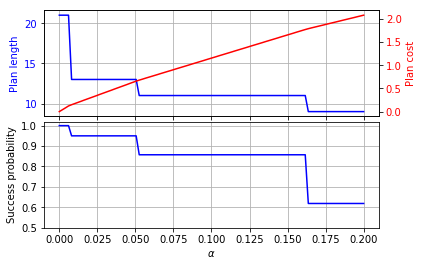

In [5]:
plot_results_actl(alphas, plan_prob, [len(p) for p in plans], [c/10000 for c in plan_cost])

In [6]:
print_plan("1st plan", plans[0])
print_plan("2nd plan", plans[int((0.025 - 0)*99/(0.2))])
print_plan("3rd plan", plans[int((0.1 - 0)*99/(0.2))])
print_plan("4th plan", plans[int((0.175 - 0)*99/(0.2))])

1st plan (21 actions):
  (move-to-land x_1_1 x_1_0)
  (move-to-land x_1_0 x_2_0)
  (move-to-land x_2_0 x_3_0)
  (move-to-land x_3_0 x_4_0)
  (move-to-land x_4_0 x_5_0)
  (pick-pickaxe x_5_0)
  (move-to-land x_5_0 x_4_0)
  (move-to-land x_4_0 x_4_1)
  (move-to-land x_4_1 x_4_2)
  (break-boulder x_4_2 x_4_3)
  (move-to-land x_4_2 x_4_3)
  (move-to-land x_4_3 x_4_4)
  (move-to-land x_4_4 x_4_5)
  (move-to-land x_4_5 x_3_5)
  (move-to-land x_3_5 x_3_6)
  (move-to-land x_3_6 x_2_6)
  (move-to-land x_2_6 x_2_7)
  (move-to-land x_2_7 x_2_8)
  (move-to-land x_2_8 x_1_8)
  (move-to-land x_1_8 x_0_8)
  (reach-goal x_0_8)
2nd plan (13 actions):
  (move-to-land x_1_1 x_2_1)
  (move-to-land x_2_1 x_2_2)
  (move-to-land x_2_2 x_3_2)
  (move-to-land x_3_2 x_3_3)
  (move-to-shallow-water x_3_3 x_3_4)
  (move-to-land x_3_4 x_3_5)
  (move-to-land x_3_5 x_3_6)
  (move-to-land x_3_6 x_2_6)
  (move-to-land x_2_6 x_2_7)
  (move-to-land x_2_7 x_2_8)
  (move-to-land x_2_8 x_1_8)
  (move-to-land x_1_8 x_0_8)
 

In [7]:
problem = parse_file(problems[2], "problem", domain)

alphas = []
plan_cost = []
plan_prob = []
plans = []

for alpha in tqdm.tqdm(list(linspace(0, 0.2, 100))):
    determinizer.alpha = alpha
    determinizer.reset()
    deterministic_problem = determinizer(problem)
    result = solver(deterministic_problem)
    assert result["plan-found"]
    cost = result["total-cost"]
    prob, plan = determinizer.process_plan_trace(result["plan"])
    alphas.append(alpha)
    plan_cost.append(cost)
    plan_prob.append(prob)
    plans.append(plan)

100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


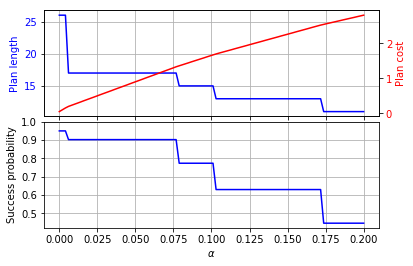

In [8]:
plot_results_actl(alphas, plan_prob, [len(p) for p in plans], [c/10000 for c in plan_cost])

In [9]:
print_plan("1st plan", plans[0])
print_plan("2nd plan", plans[int((0.025 - 0)*99/(0.2))])
print_plan("3rd plan", plans[int((0.085 - 0)*99/(0.2))])
print_plan("4th plan", plans[int((0.150 - 0)*99/(0.2))])
print_plan("5th plan", plans[int((0.185 - 0)*99/(0.2))])

1st plan (26 actions):
  (move-to-land x_2_0 x_1_0)
  (move-to-shallow-water x_1_0 x_1_1)
  (move-to-land x_1_1 x_1_2)
  (move-to-land x_1_2 x_1_3)
  (pick-pickaxe x_1_3)
  (move-to-land x_1_3 x_0_3)
  (break-boulder x_0_3 x_0_2)
  (move-to-land x_0_3 x_0_2)
  (move-to-land x_0_2 x_0_1)
  (move-to-land x_0_1 x_0_0)
  (move-to-land x_0_0 x_1_0)
  (move-to-land x_1_0 x_2_0)
  (move-to-land x_2_0 x_3_0)
  (move-to-land x_3_0 x_4_0)
  (move-to-land x_4_0 x_5_0)
  (move-to-land x_5_0 x_5_1)
  (move-to-land x_5_1 x_5_2)
  (move-to-land x_5_2 x_5_3)
  (move-to-land x_5_3 x_5_4)
  (move-to-land x_5_4 x_5_5)
  (break-boulder x_5_5 x_5_6)
  (move-to-land x_5_5 x_5_6)
  (move-to-land x_5_6 x_5_7)
  (move-to-land x_5_7 x_5_8)
  (move-to-land x_5_8 x_4_8)
  (reach-goal x_4_8)
2nd plan (17 actions):
  (move-to-land x_2_0 x_1_0)
  (move-to-shallow-water x_1_0 x_1_1)
  (move-to-land x_1_1 x_1_2)
  (move-to-land x_1_2 x_1_3)
  (pick-pickaxe x_1_3)
  (move-to-land x_1_3 x_0_3)
  (move-to-land x_0_3 x_0_